In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist
import keras_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras_utils.set_keras_session()

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [6]:
def pad(image, padding=2):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

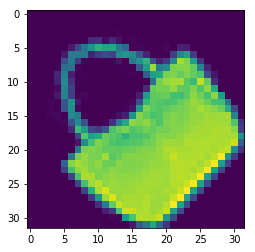

In [7]:
plt.imshow(cv2_rotate(pad(X_train[100]), 45))

In [8]:
augmented_rotations_per_sample = 3

In [9]:
def generate_random_rotations(X, Y, n_rotations_per_sample, rot_range=10):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(-rot_range, rot_range)
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [10]:
nb_classes = keras.utils.to_categorical(Y_train).shape[1]

In [11]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [12]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

def cosine_proximity_unitary(y_true, y_pred):
    
    dot_product_loss = losses.cosine_proximity(y_true, y_pred)
    unit_circle_loss = K.square(1 - (K.square(y_pred[:, 0]) + K.square(y_pred[:, 1])))
    return dot_product_loss + 0.05 * unit_circle_loss


def build_model(use_labels=True, use_rotation=True, rot_range=-1):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.25)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(2*rot_range, activation='softmax', name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], 
                      metrics={'y': 'accuracy', 'r': [keras_utils.angle_error, keras_utils.cos_error]},
                      loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    #model.summary()
    
    return model

In [13]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [14]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train]
        y_test = [Y_test_onehot, R_test]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train
        y_test = R_test
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [15]:
histories = []
diff_degrees = []
y_preds = []
r_preds = []

use_labels = True
use_rotation = True

rot_step = 10

for rot_range in range(10, 180 + rot_step, rot_step):
    
    print('Training on rotation range of +-', rot_range)

    X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                                  augmented_rotations_per_sample, rot_range)
    X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                               augmented_rotations_per_sample, rot_range)

    R_train, R_test = R_train + rot_range, R_test + rot_range
    R_train = keras.utils.to_categorical(R_train, 2*rot_range)
    R_test = keras.utils.to_categorical(R_test, 2*rot_range)
    
    Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
    Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

    nb_classes = Y_train_onehot.shape[1]

    #R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

    #R_train_sin_cos = create_rot_sin_cos(R_train_radians)
    #R_test_sin_cos = create_rot_sin_cos(R_test_radians)

    alpha = K.variable(0.9)
    beta = K.variable(0.1)
    model = build_model(use_labels, use_rotation, rot_range)

    history = train_model(model, use_labels, use_rotation).history
    histories.append(history)
    
    Y_pred, R_pred = model.predict(X_test_rot)
    R_test = np.argmax(R_test, axis=1) - rot_range
    R_pred = np.argmax(R_pred, axis=1) - rot_range

    diff_degree = np.abs(R_pred - R_test)
    diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
    print(np.mean(diff_degree))
    
    diff_degrees.append(diff_degree)
    y_preds.append(Y_pred)
    r_preds.append(R_pred)


  2%|▏         | 1291/60000 [00:00<00:04, 12905.92it/s]

Training on rotation range of +- 10


100%|██████████| 10000/10000 [00:00<00:00, 12768.05it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 290us/step - loss: 0.7638 - y_loss: 0.5279 - r_loss: 2.8866 - y_acc: 0.8506 - r_angle_error: 4.4464 - r_cos_error: -0.9955 - val_loss: 0.5166 - val_y_loss: 0.3133 - val_r_loss: 2.3468 - val_y_acc: 0.8861 - val_r_angle_error: 1.7379 - val_r_cos_error: -0.9992
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.5127 - y_loss: 0.2788 - r_loss: 2.6185 - y_acc: 0.8954 - r_angle_error: 3.5408 - r_cos_error: -0.9969 - val_loss: 0.4868 - val_y_loss: 0.2925 - val_r_loss: 2.2352 - val_y_acc: 0.8976 - val_r_angle_error: 1.3484 - val_r_cos_error: -0.9995
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4681 - y_loss: 0.2358 - r_loss: 2.5591 - y_acc: 0.9107 - r_angle_error: 3.2374 - r_cos_error: -0.9973 - val_loss: 0.4549 - val_y_loss: 0.2706 - val_r_loss: 2.1129 - val_y_acc: 0.9061 - val_r_angle_error: 1.2468 - val_r

  5%|▍         | 2998/60000 [00:00<00:03, 14983.64it/s]

1.0727666666666666
Training on rotation range of +- 20


100%|██████████| 10000/10000 [00:00<00:00, 11981.93it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 283us/step - loss: 2.3043 - y_loss: 2.2046 - r_loss: 3.2016 - y_acc: 0.7409 - r_angle_error: 7.7716 - r_cos_error: -0.9804 - val_loss: 0.5215 - val_y_loss: 0.3491 - val_r_loss: 2.0730 - val_y_acc: 0.8729 - val_r_angle_error: 1.3729 - val_r_cos_error: -0.9993
Epoch 2/10
180000/180000 [==============================] - 50s 281us/step - loss: 0.5366 - y_loss: 0.3326 - r_loss: 2.3728 - y_acc: 0.8772 - r_angle_error: 3.1540 - r_cos_error: -0.9959 - val_loss: 0.4622 - val_y_loss: 0.3137 - val_r_loss: 1.7993 - val_y_acc: 0.8845 - val_r_angle_error: 1.0735 - val_r_cos_error: -0.9995
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4762 - y_loss: 0.2858 - r_loss: 2.1901 - y_acc: 0.8930 - r_angle_error: 2.6688 - r_cos_error: -0.9966 - val_loss: 0.4263 - val_y_loss: 0.2954 - val_r_loss: 1.6046 - val_y_acc: 0.8922 - val_r_angle_error: 0.7968 - val_r

  2%|▏         | 1248/60000 [00:00<00:04, 12476.53it/s]

0.47273333333333334
Training on rotation range of +- 30


100%|██████████| 10000/10000 [00:00<00:00, 12720.49it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 50s 275us/step - loss: 0.9706 - y_loss: 0.6797 - r_loss: 3.5878 - y_acc: 0.8108 - r_angle_error: 12.0288 - r_cos_error: -0.9553 - val_loss: 0.5685 - val_y_loss: 0.3527 - val_r_loss: 2.5109 - val_y_acc: 0.8691 - val_r_angle_error: 2.1400 - val_r_cos_error: -0.9983
Epoch 2/10
180000/180000 [==============================] - 43s 240us/step - loss: 0.6096 - y_loss: 0.3459 - r_loss: 2.9834 - y_acc: 0.8721 - r_angle_error: 6.2546 - r_cos_error: -0.9857 - val_loss: 0.5221 - val_y_loss: 0.3232 - val_r_loss: 2.3129 - val_y_acc: 0.8813 - val_r_angle_error: 1.7455 - val_r_cos_error: -0.9989
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.5523 - y_loss: 0.2966 - r_loss: 2.8533 - y_acc: 0.8897 - r_angle_error: 5.8143 - r_cos_error: -0.9855 - val_loss: 0.4895 - val_y_loss: 0.2973 - val_r_loss: 2.2193 - val_y_acc: 0.8912 - val_r_angle_error: 1.5051 - val_

  2%|▏         | 1175/60000 [00:00<00:05, 11744.30it/s]

1.0958
Training on rotation range of +- 40


100%|██████████| 10000/10000 [00:00<00:00, 12152.81it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 284us/step - loss: 1.1070 - y_loss: 0.7908 - r_loss: 3.9531 - y_acc: 0.7948 - r_angle_error: 16.1976 - r_cos_error: -0.9241 - val_loss: 0.6291 - val_y_loss: 0.3772 - val_r_loss: 2.8962 - val_y_acc: 0.8644 - val_r_angle_error: 2.6535 - val_r_cos_error: -0.9971
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.6774 - y_loss: 0.3678 - r_loss: 3.4638 - y_acc: 0.8643 - r_angle_error: 11.5025 - r_cos_error: -0.9504 - val_loss: 0.5730 - val_y_loss: 0.3436 - val_r_loss: 2.6378 - val_y_acc: 0.8734 - val_r_angle_error: 2.1060 - val_r_cos_error: -0.9982
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.6162 - y_loss: 0.3209 - r_loss: 3.2736 - y_acc: 0.8795 - r_angle_error: 10.1064 - r_cos_error: -0.9561 - val_loss: 0.5423 - val_y_loss: 0.3236 - val_r_loss: 2.5101 - val_y_acc: 0.8789 - val_r_angle_error: 1.8645 - va

  2%|▏         | 1136/60000 [00:00<00:05, 11357.38it/s]

1.6125666666666667
Training on rotation range of +- 50


100%|██████████| 10000/10000 [00:00<00:00, 12532.10it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 1.2796 - y_loss: 0.9468 - r_loss: 4.2746 - y_acc: 0.7667 - r_angle_error: 20.3510 - r_cos_error: -0.8855 - val_loss: 0.7209 - val_y_loss: 0.4218 - val_r_loss: 3.4125 - val_y_acc: 0.8474 - val_r_angle_error: 4.1839 - val_r_cos_error: -0.9892
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.7544 - y_loss: 0.4107 - r_loss: 3.8477 - y_acc: 0.8481 - r_angle_error: 15.3155 - r_cos_error: -0.9131 - val_loss: 0.6571 - val_y_loss: 0.3738 - val_r_loss: 3.2070 - val_y_acc: 0.8627 - val_r_angle_error: 3.9497 - val_r_cos_error: -0.9837
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.7029 - y_loss: 0.3590 - r_loss: 3.7973 - y_acc: 0.8659 - r_angle_error: 15.4533 - r_cos_error: -0.9088 - val_loss: 0.6250 - val_y_loss: 0.3497 - val_r_loss: 3.1029 - val_y_acc: 0.8736 - val_r_angle_error: 3.5776 - va

  2%|▏         | 1227/60000 [00:00<00:04, 12260.54it/s]

2.7094
Training on rotation range of +- 60


100%|██████████| 10000/10000 [00:00<00:00, 12910.60it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 1.3245 - y_loss: 1.0045 - r_loss: 4.2043 - y_acc: 0.7600 - r_angle_error: 31.0341 - r_cos_error: -0.7269 - val_loss: 0.6823 - val_y_loss: 0.4284 - val_r_loss: 2.9675 - val_y_acc: 0.8431 - val_r_angle_error: 9.7000 - val_r_cos_error: -0.9115
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.7249 - y_loss: 0.4152 - r_loss: 3.5119 - y_acc: 0.8476 - r_angle_error: 22.6357 - r_cos_error: -0.7955 - val_loss: 0.6032 - val_y_loss: 0.3774 - val_r_loss: 2.6357 - val_y_acc: 0.8608 - val_r_angle_error: 3.3820 - val_r_cos_error: -0.9824
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.6630 - y_loss: 0.3602 - r_loss: 3.3883 - y_acc: 0.8664 - r_angle_error: 20.3566 - r_cos_error: -0.8192 - val_loss: 0.5786 - val_y_loss: 0.3574 - val_r_loss: 2.5688 - val_y_acc: 0.8669 - val_r_angle_error: 3.0699 - va

  2%|▏         | 1027/60000 [00:00<00:05, 10261.67it/s]

2.3027333333333333
Training on rotation range of +- 70


100%|██████████| 10000/10000 [00:00<00:00, 12029.34it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 42s 233us/step - loss: 1.5472 - y_loss: 1.2613 - r_loss: 4.1200 - y_acc: 0.7388 - r_angle_error: 24.6129 - r_cos_error: -0.7948 - val_loss: 0.6860 - val_y_loss: 0.4551 - val_r_loss: 2.7643 - val_y_acc: 0.8341 - val_r_angle_error: 4.2544 - val_r_cos_error: -0.9755
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.7235 - y_loss: 0.4464 - r_loss: 3.2175 - y_acc: 0.8360 - r_angle_error: 14.4543 - r_cos_error: -0.8767 - val_loss: 0.6180 - val_y_loss: 0.4117 - val_r_loss: 2.4749 - val_y_acc: 0.8488 - val_r_angle_error: 3.3380 - val_r_cos_error: -0.9817
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.6534 - y_loss: 0.3870 - r_loss: 3.0514 - y_acc: 0.8565 - r_angle_error: 12.7508 - r_cos_error: -0.8929 - val_loss: 0.5778 - val_y_loss: 0.3814 - val_r_loss: 2.3453 - val_y_acc: 0.8626 - val_r_angle_error: 2.9554 - va

  2%|▏         | 1300/60000 [00:00<00:04, 12988.83it/s]

2.369
Training on rotation range of +- 80


100%|██████████| 10000/10000 [00:00<00:00, 12181.71it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 286us/step - loss: 1.7213 - y_loss: 1.4204 - r_loss: 4.4300 - y_acc: 0.7213 - r_angle_error: 28.3279 - r_cos_error: -0.7677 - val_loss: 0.7391 - val_y_loss: 0.4673 - val_r_loss: 3.1848 - val_y_acc: 0.8295 - val_r_angle_error: 6.0489 - val_r_cos_error: -0.9616
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.7930 - y_loss: 0.4700 - r_loss: 3.6998 - y_acc: 0.8288 - r_angle_error: 20.2605 - r_cos_error: -0.8318 - val_loss: 0.6570 - val_y_loss: 0.4171 - val_r_loss: 2.8163 - val_y_acc: 0.8477 - val_r_angle_error: 4.3932 - val_r_cos_error: -0.9739
Epoch 3/10
180000/180000 [==============================] - 44s 246us/step - loss: 0.7168 - y_loss: 0.4091 - r_loss: 3.4859 - y_acc: 0.8484 - r_angle_error: 18.3941 - r_cos_error: -0.8436 - val_loss: 0.6188 - val_y_loss: 0.3968 - val_r_loss: 2.6171 - val_y_acc: 0.8540 - val_r_angle_error: 3.9633 - va

  2%|▏         | 1200/60000 [00:00<00:04, 11987.49it/s]

3.413466666666667
Training on rotation range of +- 90


100%|██████████| 10000/10000 [00:00<00:00, 12526.09it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 286us/step - loss: 1.4398 - y_loss: 1.0847 - r_loss: 4.6358 - y_acc: 0.7204 - r_angle_error: 38.0363 - r_cos_error: -0.6461 - val_loss: 0.7606 - val_y_loss: 0.4833 - val_r_loss: 3.2567 - val_y_acc: 0.8268 - val_r_angle_error: 6.8337 - val_r_cos_error: -0.9541
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.8232 - y_loss: 0.4876 - r_loss: 3.8438 - y_acc: 0.8211 - r_angle_error: 25.7799 - r_cos_error: -0.7654 - val_loss: 0.6741 - val_y_loss: 0.4227 - val_r_loss: 2.9363 - val_y_acc: 0.8449 - val_r_angle_error: 5.2127 - val_r_cos_error: -0.9663
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.7547 - y_loss: 0.4274 - r_loss: 3.7002 - y_acc: 0.8424 - r_angle_error: 23.7669 - r_cos_error: -0.7849 - val_loss: 0.6404 - val_y_loss: 0.3990 - val_r_loss: 2.8129 - val_y_acc: 0.8561 - val_r_angle_error: 5.0620 - va

  3%|▎         | 1501/60000 [00:00<00:03, 14997.68it/s]

4.250066666666667
Training on rotation range of +- 100


100%|██████████| 10000/10000 [00:00<00:00, 12295.63it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 286us/step - loss: 1.2072 - y_loss: 0.8169 - r_loss: 4.7193 - y_acc: 0.7429 - r_angle_error: 49.4570 - r_cos_error: -0.5057 - val_loss: 0.7833 - val_y_loss: 0.4860 - val_r_loss: 3.4592 - val_y_acc: 0.8263 - val_r_angle_error: 12.2869 - val_r_cos_error: -0.8886
Epoch 2/10
180000/180000 [==============================] - 50s 279us/step - loss: 0.8404 - y_loss: 0.4855 - r_loss: 4.0346 - y_acc: 0.8230 - r_angle_error: 35.9880 - r_cos_error: -0.6365 - val_loss: 0.6952 - val_y_loss: 0.4304 - val_r_loss: 3.0786 - val_y_acc: 0.8441 - val_r_angle_error: 8.0310 - val_r_cos_error: -0.9326
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.7669 - y_loss: 0.4208 - r_loss: 3.8821 - y_acc: 0.8447 - r_angle_error: 32.8293 - r_cos_error: -0.6709 - val_loss: 0.6708 - val_y_loss: 0.4162 - val_r_loss: 2.9620 - val_y_acc: 0.8481 - val_r_angle_error: 6.1698 - v

  2%|▏         | 1463/60000 [00:00<00:04, 14618.51it/s]

4.701066666666667
Training on rotation range of +- 110


100%|██████████| 10000/10000 [00:00<00:00, 12061.62it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 287us/step - loss: 2.4507 - y_loss: 2.2178 - r_loss: 4.5476 - y_acc: 0.6558 - r_angle_error: 43.6401 - r_cos_error: -0.5588 - val_loss: 0.7702 - val_y_loss: 0.5245 - val_r_loss: 2.9816 - val_y_acc: 0.8112 - val_r_angle_error: 7.4640 - val_r_cos_error: -0.9401
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.8228 - y_loss: 0.5292 - r_loss: 3.4659 - y_acc: 0.8069 - r_angle_error: 23.4707 - r_cos_error: -0.7707 - val_loss: 0.6743 - val_y_loss: 0.4564 - val_r_loss: 2.6353 - val_y_acc: 0.8374 - val_r_angle_error: 5.6139 - val_r_cos_error: -0.9573
Epoch 3/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.7385 - y_loss: 0.4576 - r_loss: 3.2662 - y_acc: 0.8306 - r_angle_error: 20.6439 - r_cos_error: -0.7994 - val_loss: 0.6326 - val_y_loss: 0.4248 - val_r_loss: 2.5031 - val_y_acc: 0.8455 - val_r_angle_error: 5.1101 - va

  2%|▏         | 1253/60000 [00:00<00:04, 12519.83it/s]

3.8293333333333335
Training on rotation range of +- 120


100%|██████████| 10000/10000 [00:00<00:00, 11798.23it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 288us/step - loss: 3.0624 - y_loss: 2.8859 - r_loss: 4.6516 - y_acc: 0.6188 - r_angle_error: 50.9750 - r_cos_error: -0.4678 - val_loss: 0.7955 - val_y_loss: 0.5455 - val_r_loss: 3.0456 - val_y_acc: 0.8030 - val_r_angle_error: 7.9832 - val_r_cos_error: -0.9367
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.8568 - y_loss: 0.5544 - r_loss: 3.5783 - y_acc: 0.7982 - r_angle_error: 27.7858 - r_cos_error: -0.7209 - val_loss: 0.7068 - val_y_loss: 0.4809 - val_r_loss: 2.7396 - val_y_acc: 0.8245 - val_r_angle_error: 6.1894 - val_r_cos_error: -0.9523
Epoch 3/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.7685 - y_loss: 0.4793 - r_loss: 3.3708 - y_acc: 0.8237 - r_angle_error: 23.4011 - r_cos_error: -0.7684 - val_loss: 0.6603 - val_y_loss: 0.4446 - val_r_loss: 2.6015 - val_y_acc: 0.8391 - val_r_angle_error: 5.5973 - va

  2%|▏         | 1238/60000 [00:00<00:04, 12374.23it/s]

4.075633333333333
Training on rotation range of +- 130


100%|██████████| 10000/10000 [00:00<00:00, 12281.95it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 288us/step - loss: 2.0830 - y_loss: 1.7801 - r_loss: 4.8084 - y_acc: 0.6649 - r_angle_error: 54.4792 - r_cos_error: -0.4238 - val_loss: 0.8125 - val_y_loss: 0.5469 - val_r_loss: 3.2028 - val_y_acc: 0.8047 - val_r_angle_error: 9.3886 - val_r_cos_error: -0.9218
Epoch 2/10
180000/180000 [==============================] - 43s 240us/step - loss: 0.8762 - y_loss: 0.5592 - r_loss: 3.7296 - y_acc: 0.7969 - r_angle_error: 29.1346 - r_cos_error: -0.7082 - val_loss: 0.7156 - val_y_loss: 0.4845 - val_r_loss: 2.7950 - val_y_acc: 0.8230 - val_r_angle_error: 7.0785 - val_r_cos_error: -0.9427
Epoch 3/10
180000/180000 [==============================] - 49s 269us/step - loss: 0.7920 - y_loss: 0.4868 - r_loss: 3.5383 - y_acc: 0.8219 - r_angle_error: 26.0312 - r_cos_error: -0.7413 - val_loss: 0.6800 - val_y_loss: 0.4494 - val_r_loss: 2.7555 - val_y_acc: 0.8358 - val_r_angle_error: 6.1677 - va

  2%|▏         | 1232/60000 [00:00<00:04, 12309.65it/s]

5.4495
Training on rotation range of +- 140


100%|██████████| 10000/10000 [00:00<00:00, 12125.64it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 289us/step - loss: 13.6080 - y_loss: 14.4920 - r_loss: 5.6524 - y_acc: 0.1007 - r_angle_error: 88.6224 - r_cos_error: -0.0114 - val_loss: 13.6192 - val_y_loss: 14.5063 - val_r_loss: 5.6350 - val_y_acc: 0.1000 - val_r_angle_error: 85.9214 - val_r_cos_error: -0.0661
Epoch 2/10
180000/180000 [==============================] - 51s 282us/step - loss: 13.6191 - y_loss: 14.5063 - r_loss: 5.6347 - y_acc: 0.1000 - r_angle_error: 86.4387 - r_cos_error: -0.0553 - val_loss: 13.6192 - val_y_loss: 14.5063 - val_r_loss: 5.6352 - val_y_acc: 0.1000 - val_r_angle_error: 97.5941 - val_r_cos_error: 0.1178


  2%|▏         | 1151/60000 [00:00<00:05, 11505.65it/s]

97.59413333333333
Training on rotation range of +- 150


100%|██████████| 10000/10000 [00:00<00:00, 12003.18it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 289us/step - loss: 1.5504 - y_loss: 1.1787 - r_loss: 4.8958 - y_acc: 0.6755 - r_angle_error: 60.9288 - r_cos_error: -0.3401 - val_loss: 0.8489 - val_y_loss: 0.5759 - val_r_loss: 3.3057 - val_y_acc: 0.7927 - val_r_angle_error: 10.5290 - val_r_cos_error: -0.9101
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.9195 - y_loss: 0.5828 - r_loss: 3.9497 - y_acc: 0.7886 - r_angle_error: 38.7442 - r_cos_error: -0.5914 - val_loss: 0.7494 - val_y_loss: 0.5031 - val_r_loss: 2.9658 - val_y_acc: 0.8185 - val_r_angle_error: 8.3172 - val_r_cos_error: -0.9301
Epoch 3/10
180000/180000 [==============================] - 41s 225us/step - loss: 0.8298 - y_loss: 0.5072 - r_loss: 3.7337 - y_acc: 0.8148 - r_angle_error: 33.4673 - r_cos_error: -0.6509 - val_loss: 0.7025 - val_y_loss: 0.4701 - val_r_loss: 2.7945 - val_y_acc: 0.8286 - val_r_angle_error: 7.3432 - v

  2%|▏         | 1097/60000 [00:00<00:05, 10964.63it/s]

5.8536
Training on rotation range of +- 160


100%|██████████| 10000/10000 [00:00<00:00, 11957.83it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 290us/step - loss: 13.6305 - y_loss: 14.5022 - r_loss: 5.7844 - y_acc: 0.1001 - r_angle_error: 92.2570 - r_cos_error: 0.0322 - val_loss: 13.6325 - val_y_loss: 14.5063 - val_r_loss: 5.7683 - val_y_acc: 0.1000 - val_r_angle_error: 88.9746 - val_r_cos_error: -0.0194
Epoch 2/10
180000/180000 [==============================] - 40s 224us/step - loss: 13.6325 - y_loss: 14.5063 - r_loss: 5.7680 - y_acc: 0.1000 - r_angle_error: 88.8907 - r_cos_error: -0.0181 - val_loss: 13.6325 - val_y_loss: 14.5063 - val_r_loss: 5.7684 - val_y_acc: 0.1000 - val_r_angle_error: 93.2656 - val_r_cos_error: 0.0530


  2%|▏         | 1344/60000 [00:00<00:04, 13436.84it/s]

93.26556666666667
Training on rotation range of +- 170


100%|██████████| 10000/10000 [00:00<00:00, 12197.78it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 289us/step - loss: 1.5094 - y_loss: 1.0722 - r_loss: 5.4442 - y_acc: 0.6762 - r_angle_error: 79.9343 - r_cos_error: -0.1166 - val_loss: 0.9525 - val_y_loss: 0.5870 - val_r_loss: 4.2429 - val_y_acc: 0.7906 - val_r_angle_error: 33.0986 - val_r_cos_error: -0.6570
Epoch 2/10
180000/180000 [==============================] - 50s 278us/step - loss: 0.9955 - y_loss: 0.5988 - r_loss: 4.5656 - y_acc: 0.7837 - r_angle_error: 59.5531 - r_cos_error: -0.3526 - val_loss: 0.8079 - val_y_loss: 0.5137 - val_r_loss: 3.4559 - val_y_acc: 0.8135 - val_r_angle_error: 16.6563 - val_r_cos_error: -0.8383
Epoch 3/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.9031 - y_loss: 0.5214 - r_loss: 4.3378 - y_acc: 0.8081 - r_angle_error: 54.6161 - r_cos_error: -0.4087 - val_loss: 0.7638 - val_y_loss: 0.4842 - val_r_loss: 3.2794 - val_y_acc: 0.8219 - val_r_angle_error: 11.2180 -

  3%|▎         | 1540/60000 [00:00<00:03, 15392.82it/s]

7.700333333333333
Training on rotation range of +- 180


100%|██████████| 10000/10000 [00:00<00:00, 13880.84it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 28s 158us/step - loss: 2.4471 - y_loss: 2.1279 - r_loss: 5.3193 - y_acc: 0.6156 - r_angle_error: 75.3228 - r_cos_error: -0.1716 - val_loss: 0.9432 - val_y_loss: 0.6303 - val_r_loss: 3.7599 - val_y_acc: 0.7784 - val_r_angle_error: 18.7750 - val_r_cos_error: -0.8189
Epoch 2/10
180000/180000 [==============================] - 27s 148us/step - loss: 0.9990 - y_loss: 0.6403 - r_loss: 4.2276 - y_acc: 0.7702 - r_angle_error: 47.7292 - r_cos_error: -0.4902 - val_loss: 0.8029 - val_y_loss: 0.5513 - val_r_loss: 3.0675 - val_y_acc: 0.8014 - val_r_angle_error: 9.5957 - val_r_cos_error: -0.9158
Epoch 3/10
180000/180000 [==============================] - 27s 151us/step - loss: 0.8871 - y_loss: 0.5499 - r_loss: 3.9224 - y_acc: 0.7998 - r_angle_error: 38.8906 - r_cos_error: -0.5911 - val_loss: 0.7355 - val_y_loss: 0.4972 - val_r_loss: 2.8798 - val_y_acc: 0.8217 - val_r_angle_error: 8.2508 - v

In [18]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_cos_error', 'val_r_angle_error', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [19]:
data = np.array(list(get_data_from_histories()))

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

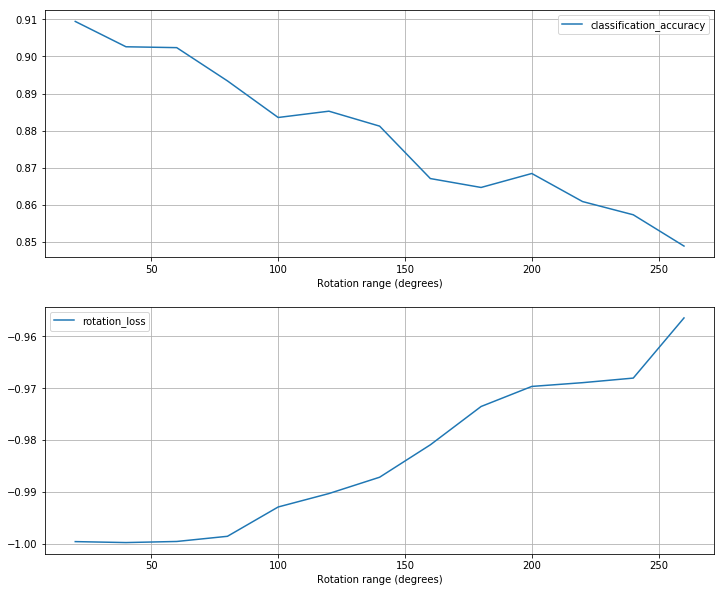

In [26]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(10, 140, 10) * 2, data[:, 4][:13], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(10, 140, 10) * 2, data[:, 1][:13], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [27]:
diff_degrees = np.array(diff_degrees)

In [37]:
w = np.mean(diff_degrees, axis=1)
print(w)

[ 1.07276667  0.47273333  1.0958      1.61256667  2.7094      2.30273333
  2.369       3.41346667  4.25006667  4.70106667  3.82933333  4.07563333
  5.4495     97.59413333  5.8536     93.26556667  7.70033333  6.31563333]


In [61]:
np.percentile(diff_degrees, 99, axis=1)

array([  5.,   3.,   5.,   7.,  12.,  12.,  87.,  90.,  92.,  95.,  91.,
        92.,  95., 179.,  97., 178., 100.,  96.])

In [33]:
z = np.array([ 1.3832554 ,  1.77593382,  1.77201876,  1.92890577,  2.56119157,
        3.64702688,  4.17862631,  5.16323753,  5.82470787,  6.41361201,
        6.25119255,  7.47966726,  8.20807014,  8.64786822,  9.71438578,
        9.81888869, 10.68765806, 10.78373911])

Text(0.5,1,'Mean difference between true and predicted orientations (in degrees) as a function of the\nrotation range of the Fashion MNIST samples.\nTwo network configurations have been tested for predicting the orientation of a sample;\nthe first uses a 2 values sin and cos output trained using dot product loss; the second is a classification output, with one\n          output for each degree (the number of outputs grows with the rotation range)')

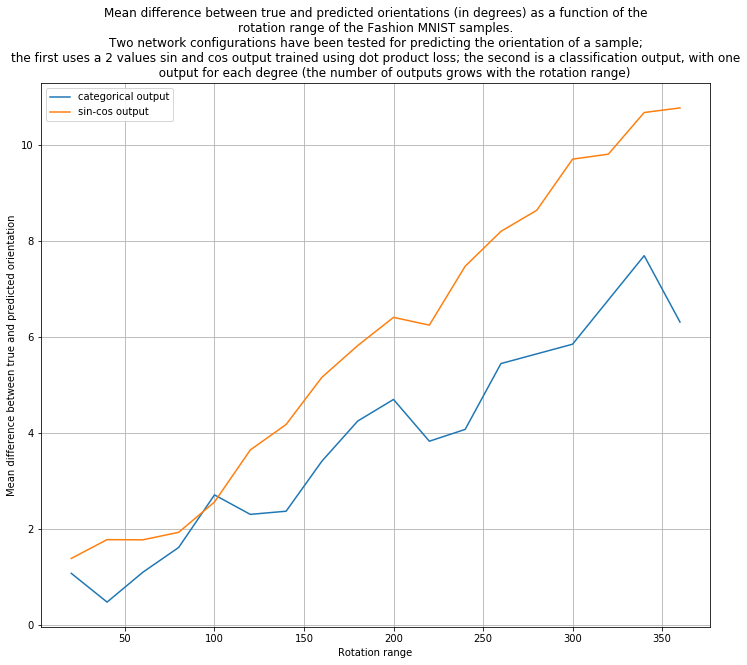

In [53]:
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 150, 170, 180]) * 2,
          np.concatenate([w[:13], [w[14]], w[16:]]), label='categorical output')
plt.plot(np.arange(10, 190, 10) * 2, z, label='sin-cos output')
plt.xlabel('Rotation range')
plt.ylabel('Mean difference between true and predicted orientation')
plt.legend()
plt.title('Mean difference between true and predicted orientations (in degrees) as a function of the\nrotation range of the Fashion MNIST samples.\nTwo network configurations have been tested for predicting the orientation of a sample;\nthe first uses a 2 values sin and cos output trained using dot product loss; the second is a classification output, with one\n output for each degree (the number of outputs grows with the rotation range)')

In [ ]:
Y_pred, R_pred = model.predict(X_test_rot)

In [ ]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else diff - 180 for diff in diff_degree])
print(np.mean(diff_degree))

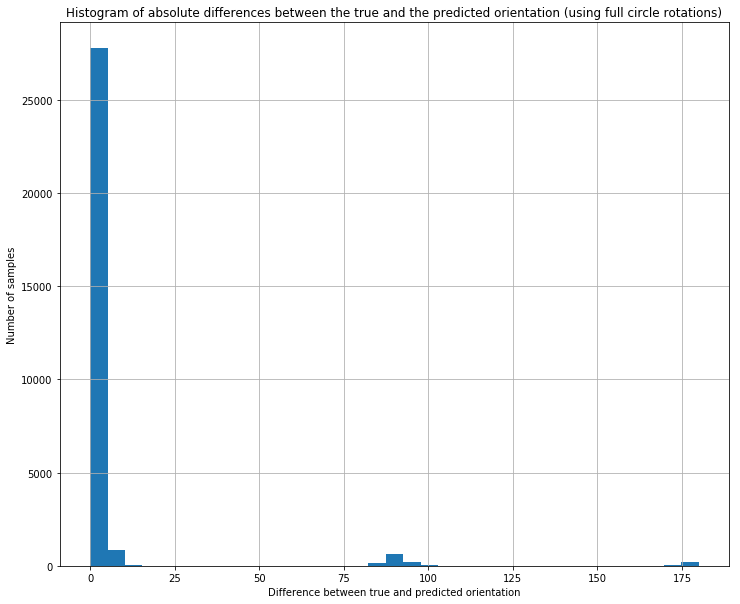

In [62]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
plt.hist(diff_degree, bins=35)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.show()

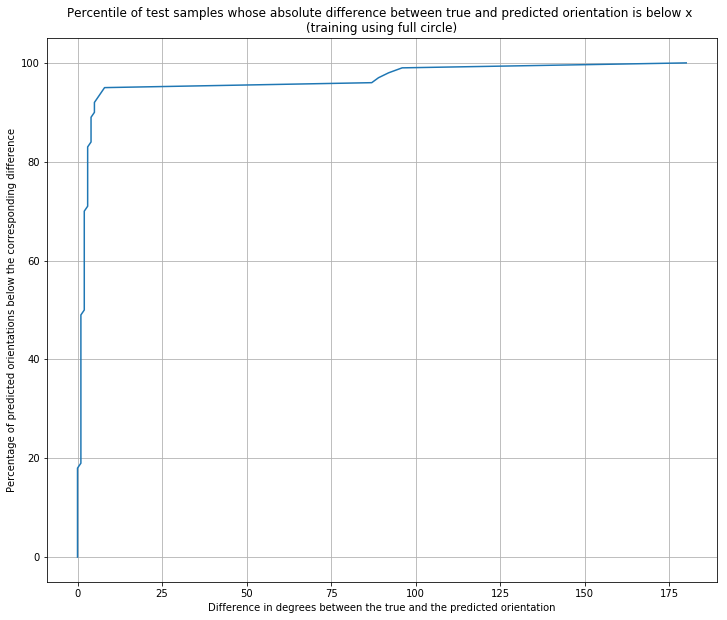

In [63]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_matrix = np.zeros((10, 10), dtype='int')

for y_true, y_pred in zip(Y_test_rot, Y_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Fashion MNIST)')
plt.imshow(confusion_matrix)
plt.colorbar()